# Case study

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/15_case_study.ipynb)

**Date**: Friday Sept 13, 2024

## LEARNING OUTCOMES
- Understand how to apply data augmentation MCMC to a real-world example
- Try applying what you have learnt this week to your own data

## Introduction

In this notebook example, we will use `gemlib` to fit a spatiotemporal SEIR model – where individuals have static locations in space, and become infected as a function of their spatial relationship to infected individuals around them – to simulated data for visceral leishmaniasis, a vector-borne neglected tropical disease. This example follows the analysis in [[1]](https://doi.org/10.1371/journal.pntd.0006453).

### Install `gemlib`

We'll start by installing the `gemlib` library:

In [1]:
%load_ext autoreload
%autoreload 2

from warnings import warn

try:
    import google.colab
    !pip install -Uq gemlib
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


and now import the modules we need for this notebook...

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spp
from typing import NamedTuple

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

import gemlib
assert gemlib.__version__ == "0.11.2"
from gemlib.distributions import DiscreteTimeStateTransitionModel

from sklearn.metrics.pairwise import haversine_distances
from math import radians

tfd = tfp.distributions

%matplotlib inline

DTYPE=np.float32

### The population dataset

We'll read in the longitude and latitude coordinates of the households of a subset (214 individuals, ~10%) of the participants in the study in Bangladesh.

In [3]:
coords_df = pd.read_csv("https://gitlab.com/gem-epidemics/practical-epidemics/-/raw/master/site/source/iddinf/data/coords.csv")

In [4]:
coords_df

,ID,HHID,latitude,longitude
0,CHBA0010101,CHBA00101,24.609751,90.307861
1,CHBA0010102,CHBA00101,24.609751,90.307861
2,CHBA0010103,CHBA00101,24.609751,90.307861
3,CHBA0010104,CHBA00101,24.609751,90.307861
4,CHBA0010201,CHBA00102,24.609930,90.307877
...,...,...,...,...
209,CHBA0021003,CHBA00210,24.611130,90.309738
210,CHBA0021101,CHBA00211,24.611050,90.309738
211,CHBA0021102,CHBA00211,24.611050,90.309738
212,CHBA0021103,CHBA00211,24.611050,90.309738


In [5]:
coords_df.loc[:,"LAT"] = [radians(_) for _ in coords_df.loc[:,"latitude"]]
coords_df.loc[:,"LON"] = [radians(_) for _ in coords_df.loc[:,"longitude"]]

Text(0, 0.5, 'Lat')

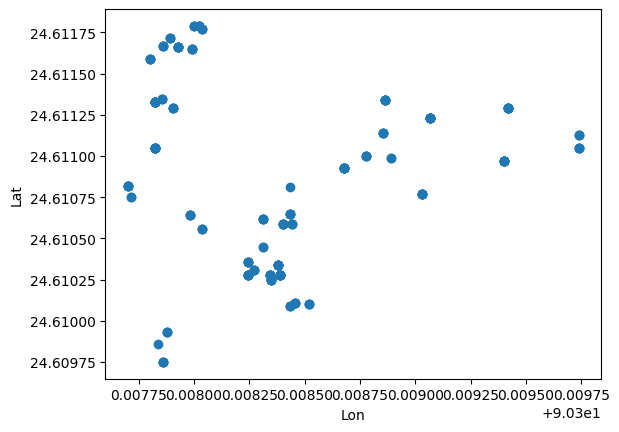

In [ ]:
plt.scatter(coords_df["longitude"], coords_df["latitude"])
plt.xlabel("Lon")
plt.ylabel("Lat")

In [ ]:
coords_df

,ID,HHID,latitude,longitude,LAT,LON
0,CHBA0010101,CHBA00101,24.609751,90.307861,0.429521,1.576170
1,CHBA0010102,CHBA00101,24.609751,90.307861,0.429521,1.576170
2,CHBA0010103,CHBA00101,24.609751,90.307861,0.429521,1.576170
3,CHBA0010104,CHBA00101,24.609751,90.307861,0.429521,1.576170
4,CHBA0010201,CHBA00102,24.609930,90.307877,0.429524,1.576170
...,...,...,...,...,...,...
209,CHBA0021003,CHBA00210,24.611130,90.309738,0.429545,1.576202
210,CHBA0021101,CHBA00211,24.611050,90.309738,0.429544,1.576202
211,CHBA0021102,CHBA00211,24.611050,90.309738,0.429544,1.576202
212,CHBA0021103,CHBA00211,24.611050,90.309738,0.429544,1.576202


### The epidemic model

We're going to model our epidemic using a SEIR model, where each individual starts as susceptible before becoming latently infected, then becoming infectious and finally recovered with solid immunity.  Here, we have 4 _states_: $S$, $E$, $I$, and $R$ representing susceptible, latently infected, infected, and recovered individuals respectively.

We'll use $x_t$ to represent the _global_ state (i.e. the configuration of S, E, I, and R states) of the epidemic at time $t$ , and say that $x^{q}_{it} = 1$ if and only if individual $i$ is in state $q$ at time $t$, and 0 otherwise.  

We have three transitions, $S \rightarrow E$, $E \rightarrow I$, and $I \rightarrow R$ for which we assume transition rates
\begin{align*}
\lambda^{SE}_i(t, x_t) &= \beta \sum_{j=1}^{N} K_{ij}(\alpha)(h_0x^{E}_{jt}+x^{I}_{jt})+\epsilon \\
\lambda^{EI}_i(t, x_t) &= \sigma \\
\lambda^{IR}_i(t, x_t) &= \gamma.
\end{align*}

We define $K(\alpha)$ to be a _spatial kernel_ function, which describes how quickly the infection rate between two individuals, $i$ and $j$, decreases as a function of distance.  For simplicity, we'll assume here that

$$
K_{ij}(\alpha) = K_0 e^{-d_{ij}/\alpha}
$$

where $d_{ij}$ is the great-circle distance between individuals $i$ and $j$, and $K_0$ is a constant defined as

$$
K_0=\frac{N}{\sum_{i=1}^N\sum_{j=1,j\neq i}^N e^{-d_{ij}/\alpha}}.
$$

#### The distance matrix and kernel

We'll start by creating a function that computes a matrix $D=(d_{ij})$ such that $d_{ij}$ is the Euclidean distance between individuals $i$ and $j$, and implement a function that returns $K(\alpha)$.


In [6]:
D = (6371*1000*haversine_distances(coords_df[['LON','LAT']])).astype(DTYPE)

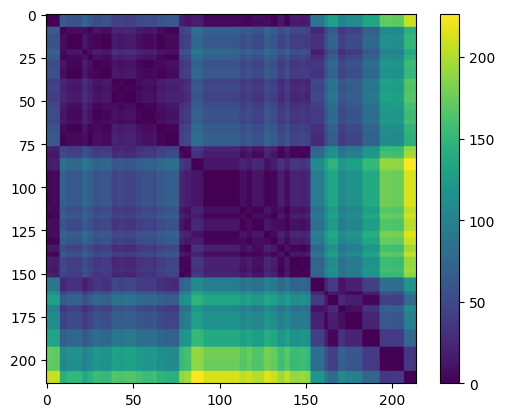

In [7]:
plt.imshow(D)
plt.colorbar()

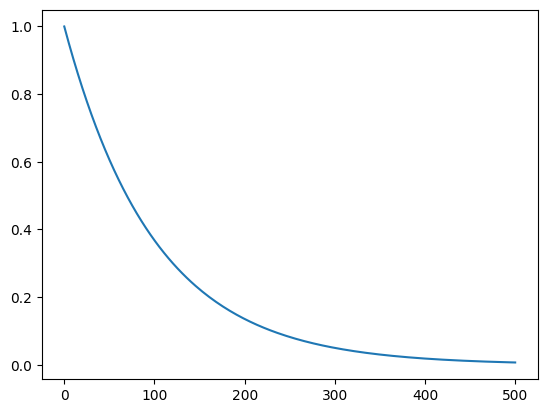

In [13]:
def spatial_kernel(distance, alpha):
    return tf.math.exp(-distance/alpha)

# Plot the spatial kernel
def plot_spatial_kernel(alpha, low=0, high=500):
    x = np.linspace(low, high, 200).astype(DTYPE)
    K = spatial_kernel(x, alpha)
    plt.plot(x, K)

plot_spatial_kernel(100)

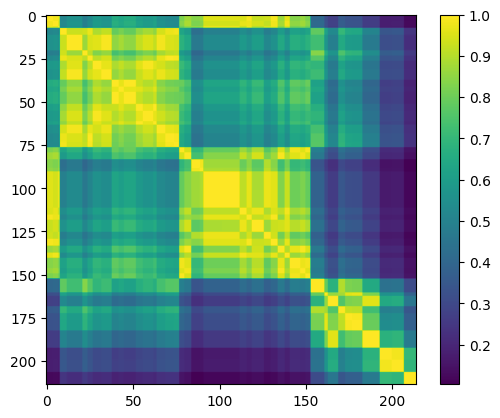

In [14]:
plt.imshow(spatial_kernel(D,100))
plt.colorbar()

Note that we're using Tensorflow maths operators inside our spatial kernel, since further on down we'll be using it inside Tensorflow-compiled code.

## Implementing the SEIR model in `gemlib`

Having specified our _states_, the _transitions_ between states, and the rates at which they occur, we can start to assemble a model for the disease process.  We'll do this using `gemlib`'s `DiscreteTimeStateTransitionModel`, which embeds the above model into a discrete-time state transition stochastic process.

### Incidence matrix

For the SEIR model we have 4 states `S, E, I, R` and 3 transitions `SE`, `EI` and `IR`. The incidence matrix is:

### Exercise 1
Set the incidence matrix for this model

In [ ]:
# incidence matrix

### Solution

In [8]:
incidence_matrix = np.array(
    [ #  SE  EI  IR
        [-1,  0,  0],  # S
        [ 1, -1,  0],  # E
        [ 0,  1, -1],  # I
        [ 0,  0,  1],  # R
    ],
    dtype=DTYPE
)

### Initial state

The initial state (or initial conditions) matrix describes the global state of the population at the start of the epidemic.

We represent this as a `[N, M]` _one-hot_ encoding for $N$ individuals and $M$ states.  Here, the _one-hot_ encoding means that for each individual (i.e. row), there is at most one 1 indicating the state in which the individual exists.

We'll start with individual id = 0 being infected, and everybody else susceptible.

In [9]:
popsize = coords_df.shape[0]

initial_state = np.concatenate(
    [
        np.repeat([[1, 0, 0, 0]], 99, axis=0),  # Susceptibles
        [[0, 0, 1, 0]], # Initial infected
        np.repeat([[1, 0, 0, 0]], 89, axis=0),
        [[0, 0, 1, 0]],
        np.repeat([[1, 0, 0, 0]], popsize-190, axis=0)
    ],
    axis=0,
).astype(DTYPE)

### Transition rate function

Now we need to express our transition rates, which we do by creating a function that returns a tuple of three arrays giving the transition rates between each state for each individual in the model.  Strict ordering of states and transition rates is maintained as for the incidence matrix above.

In [10]:
def transition_rates(t, state):
    beta = DTYPE(0.4)
    alpha = DTYPE(100.0)
    sigma = DTYPE(1/4.0)
    gamma = DTYPE(1/4.41)
    epsilon = DTYPE(3.8e-4)
    h0 = DTYPE(0.03)

    K_mat = spatial_kernel(D, alpha)
    K = tf.linalg.set_diag(K_mat, tf.zeros(K_mat.shape[0]))
    K0 = state.shape[0] / tf.reduce_sum(K)

    se_rate = beta * tf.linalg.matvec(
        K0 * K, h0*state[:,1] + state[:,2]
    ) + tf.fill((state.shape[0],), epsilon)
    ei_rate = tf.fill((state.shape[0],), sigma)
    ir_rate = tf.fill((state.shape[0],), gamma)

    return se_rate, ei_rate, ir_rate

As a check, let's make sure our transition rate function returns something sensible if supplied the initial state:

In [15]:
test_rates = transition_rates(0.0, initial_state)
print("Test rate shapes:", [x.shape for x in test_rates])

Test rate shapes: [TensorShape([214]), TensorShape([214]), TensorShape([214])]


which results in a tuple of three vectors of length $N$ as expected for the $S\rightarrow E$, $E \rightarrow I$, and $I \rightarrow R$ transitions respectively.

### The discrete-time model

### Exercise 2

Instantiate a `DiscreteTimeStateTransitionModel` using the components of the model defined above and run a simulation using the `sample` method and [0,0] as the random number seed. Use a time step of 1 (month) and 78 time steps. Plot the number of each type of transition happening in each month from the simulation output.

```
seir = DiscreteTimeStateTransitionModel(
    
)
```

### Solution

Set up the model

In [16]:
seir = DiscreteTimeStateTransitionModel(
    transition_rate_fn=transition_rates,
    incidence_matrix=incidence_matrix,
    initial_state=initial_state,
    initial_step=0,
    time_delta=1.0,
    num_steps=78
)

and run the simulation

In [17]:
seir_sim = seir.sample(seed=[0, 4])

In [ ]:
seir_sim.shape

TensorShape([78, 214, 3])

Remember `sample()` spits out a tensor of dimension `[T, N, L]` for $T$ timesteps, $N$ individuals, and $L$ transitions.  This tensor, $Z$, is such that $z^{qr}_{it} = 1$ if individual $i$ undergoes a transition from $q$ to $r$ at timestep $t$, and $z^{qr}_{it} = 0$ otherwise.

We can therefore compute the total number of each type of transition happening on each day by taking the sum across the second dimension  (i.e. $N$) of the tensor.  In the context of our SEIR model this is, of course, equivalent to plotting the daily absolute incidence of infection, infectiousness onset, and recovery events.

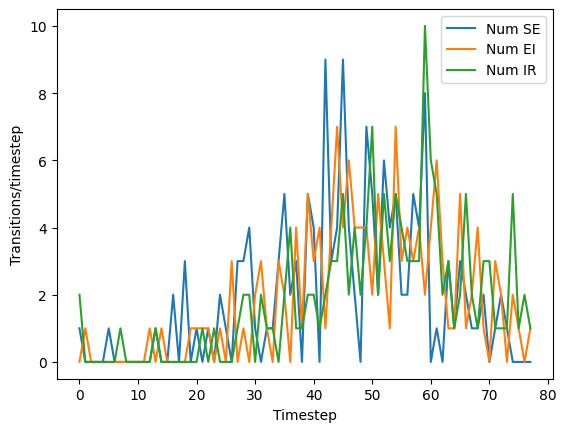

In [18]:
plt.plot(np.sum(seir_sim, axis=1), label=["Num SE", "Num EI", "Num IR"])
plt.xlabel("Timestep")
plt.ylabel("Transitions/timestep")
plt.legend()

We can also use the `compute_state` method to recover the _state_ timeseries, if we wish to plot prevalence rather than incidence:



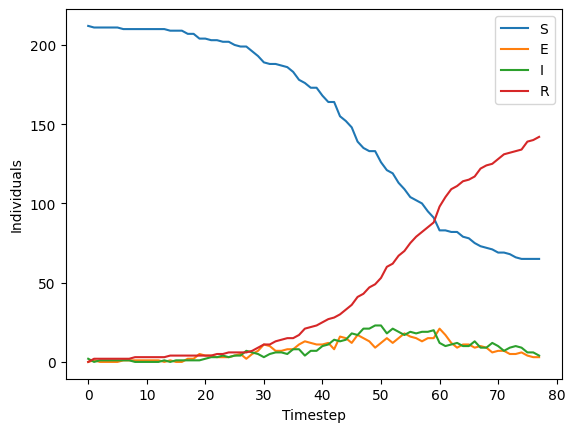

In [19]:
seir_sim_state = seir.compute_state(seir_sim)
plt.plot(np.sum(seir_sim_state, axis=1), label=["S", "E", "I", "R"])
plt.xlabel("Timestep")
plt.ylabel("Individuals")
_ = plt.legend()

In [20]:
# Total number recovered at final month
np.sum(seir_sim_state[77,:,-1])

142.0

And plot a map of the people who ended up infected

Text(0, 0.5, 'Lat')

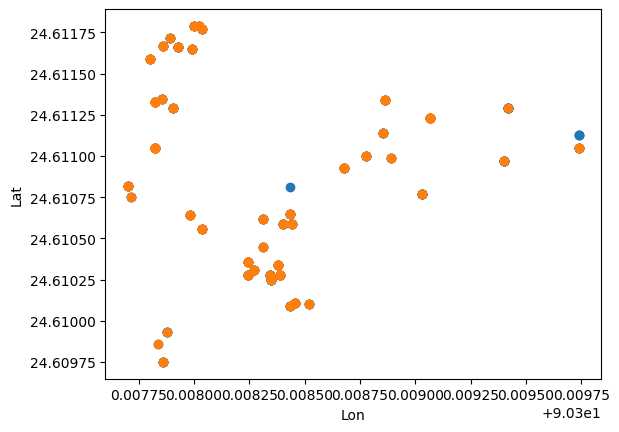

In [21]:
infected_coords = coords_df.loc[np.where(seir_sim_state[-1,:,3]==1.0)]
plt.scatter(coords_df["longitude"], coords_df["latitude"])
plt.scatter(infected_coords["longitude"], infected_coords["latitude"], label="infected")
plt.xlabel("Lon")
plt.ylabel("Lat")

In [ ]:
idcs = np.where(seir_sim==1.0)

data = np.full((popsize,3), fill_value=np.nan)

for i in range(len(idcs[0])):
    data[idcs[1][i],idcs[2][i]] = idcs[0][i]

In [ ]:
df = pd.DataFrame(data)
df

,0,1,2
0,52.0,54.0,58.0
1,66.0,71.0,NaN
2,45.0,47.0,58.0
3,NaN,NaN,NaN
4,44.0,45.0,46.0
...,...,...,...
209,NaN,NaN,NaN
210,55.0,67.0,70.0
211,NaN,NaN,NaN
212,42.0,45.0,47.0


## Inference

We now specify prior distributions for the model parameters.

Let our epidemic model be written as

$$
Z \sim \mbox{SIR}(\theta, \mathbf{x}_0)
$$

where $Z$ is the output transition events tensor (`seir_sim` above), $\mathbf{x}_0$ is the initial state, and $\theta = \{\beta,\alpha,\sigma,\gamma,\epsilon,h_0\}$ are the parameters.  We pick priors for the parameters as follows:

\begin{align*}
\beta & \sim \mbox{Gamma}(1,1) \\
\sigma & \sim \mbox{Gamma}(2,8) \\
\gamma & \sim \mbox{Gamma}(2,8) \\
\epsilon & \sim \mbox{Gamma}(1,1) \\
\alpha & \sim \mbox{Gamma}(1,1/50) \\
h_0 & \sim \mbox{Beta}(3,97)
\end{align*}



### Implementing a Bayesian model

### Exercise 3
Set up the `JointDistributionCoroutine` for this model using the template code below and the definitions above.

```
@tfd.JointDistributionCoroutine
def model():

    # Priors

    # Epidemic model
    incidence_matrix =

    initial_state =

    def transition_rates(t, state):

    seir =
    )
```

### Solution

In [ ]:
@tfd.JointDistributionCoroutine
def model():

    # Priors
    beta = yield tfd.Gamma(
        concentration=DTYPE(1.0), rate=DTYPE(1.0), force_probs_to_zero_outside_support=True, name="beta",
    )
    alpha = yield tfd.Gamma(
        concentration=DTYPE(1.0), rate=DTYPE(1/50.0), force_probs_to_zero_outside_support=True, name="alpha"
    )
    sigma = yield tfd.Gamma(
        concentration=DTYPE(2.0), rate=DTYPE(8.0), force_probs_to_zero_outside_support=True, name="sigma"
    )
    gamma = yield tfd.Gamma(
        concentration=DTYPE(2.0), rate=DTYPE(8.0), force_probs_to_zero_outside_support=True, name="gamma"
    )
    epsilon = yield tfd.Gamma(
        concentration=DTYPE(1.0), rate=DTYPE(1.0), force_probs_to_zero_outside_support=True, name="epsilon"
    )
    h0 = yield tfd.Beta(
        concentration1=DTYPE(3.0), concentration0=DTYPE(97.0), force_probs_to_zero_outside_support=True, name="h0"
    )

    # Epidemic model
    incidence_matrix = np.array(
        [ #  SE  EI  IR
            [-1,  0,  0],  # S
            [ 1, -1,  0],  # E
            [ 0,  1, -1],  # I
            [ 0,  0,  1],  # R
        ],
        dtype=DTYPE
    )

    initial_state = np.concatenate(
        [
            np.repeat([[1, 0, 0, 0]], 99, axis=0),  # Susceptibles
            [[0, 0, 1, 0]], # Initial infected
            np.repeat([[1, 0, 0, 0]], 89, axis=0),
            [[0, 0, 1, 0]],
            np.repeat([[1, 0, 0, 0]], popsize-190, axis=0)
        ],
        axis=0,
    ).astype(DTYPE)

    def transition_rates(t, state):
        K_mat = spatial_kernel(D, alpha)
        K = tf.linalg.set_diag(K_mat, tf.zeros(K_mat.shape[0]))
        K0 = state.shape[0] / tf.reduce_sum(K)

        se_rate = beta * tf.linalg.matvec(
            K0 * K, h0*state[:, 1] + state[:,2]
        ) + tf.fill((state.shape[0],), epsilon)
        ei_rate = tf.fill((state.shape[0],), sigma)
        ir_rate = tf.fill((state.shape[0],), gamma)

        return se_rate, ei_rate, ir_rate

    seir = yield DiscreteTimeStateTransitionModel(
        transition_rate_fn=transition_rates,
        incidence_matrix=incidence_matrix,
        initial_state=initial_state,
        initial_step=0,
        time_delta=1.0,
        num_steps=78,
        name="seir"
    )

### Performing data-augmentation MCMC

To make this example realistic, we're going to assume that the infection times are unobserved and try to infer them. In real life we might want to also try to infer many of the parameters of the model or at least the transmission parameters $(\beta,\alpha,\epsilon)$, but here we're going to simplify the problem and just try to estimate $\beta$ and $\alpha$ (the transmission rate parameter and the spatial kernel scale parameter) alongside the infection times.

We'll do this with a Metropolis-within-Gibbs algorithm, with an adaptive random walk step for updating the parameters and the `gemlib` implementation of the `move_events` algorithm for moving event times that we saw yesterday. `gemlib` provides a really neat interface for performing Metropolis-within-Gibbs algorithms, by chaining together MCMC kernels defined using the `MwgStep` method with the `>>` operator, to form compound kernels.

First we import the methods we need from the `gemlib.mcmc` module:

In [ ]:
from gemlib.mcmc import adaptive_rwmh
from gemlib.mcmc.discrete_time_state_transition_model import move_events
from gemlib.mcmc import mcmc
from gemlib.mcmc import multi_scan
from gemlib.mcmc import MwgStep

Then we define the kernels for the parameter updates and the infection time moves

In [ ]:
param_mh_kernel = MwgStep(
    sampling_algorithm = adaptive_rwmh(),
    target_names=["beta",
                  "alpha"]
)

se_move_kernel = MwgStep(
    sampling_algorithm=move_events(
        incidence_matrix=incidence_matrix,
        transition_index=0,
        num_units=1,
        delta_max=5,
        count_max=1,
    ),
    target_names=["seir"],
    kernel_kwargs_fn=lambda _: {"initial_conditions": initial_state}
)

and chain them together, using the `multi_scan` method to say that we want to update the infection times for 10 individuals per each Metropolis-Hastings step for the parameters:

In [ ]:
kernel = param_mh_kernel >> multi_scan(10, se_move_kernel)

We set the starting values for the parameters and event times in the chain (N.B. these values have been deliberately chosen to be close/equal to the true values)

In [ ]:
initial_position = model.sample(seir=seir_sim, beta=0.3, alpha=80, sigma=1/4.0, gamma=1/4.41, epsilon=3.8e-4, h0=0.03, seed=[0,2])

compile the MCMC sampling function

In [ ]:
@tf.function(jit_compile=True)
def sample_chain(num_samples, seed):
    return mcmc(
        num_samples = num_samples,
        sampling_algorithm=kernel,
        target_density_fn=model.log_prob,
        initial_position=initial_position,
        seed=seed
    )

and run the chain

> WARNING: the follow cell takes a while to run (~8 mins with CPU runtime)


In [ ]:
num_iterations = 1000
samples, info = sample_chain(num_iterations, seed=[0,0])

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/metropolis_hastings.py:273: UserWarning: Batched event times updates are not supported.  Using first event item only.
  pkr = self.inner_kernel.bootstrap_results(init_state)


If we plot the trace plots for $\beta$ and $\alpha$ we can see that they don't look very satisfactory:

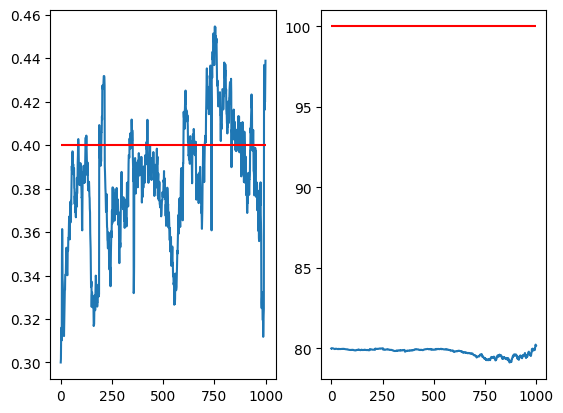

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(samples.beta)
ax[0].hlines(xmin=0, xmax=samples.beta.shape[0], y=0.4, color="red")
ax[1].plot(samples.alpha)
ax[1].hlines(xmin=0, xmax=samples.beta.shape[0], y=100, color="red")

and this seems to be confirmed by calculating the acceptance rates for the parameter updates and infection time moves

In [ ]:
param_acc_rate = np.sum(info[0].is_accepted)/num_iterations
param_acc_rate

0.924

In [ ]:
se_move_acc_rate = np.sum(info[1][0].is_accepted)/(num_iterations)
se_move_acc_rate

0.33

We can visualise the mixing of the infection times by calculating the SE transition time for each individual for each iteration

In [ ]:
# The output tensors for the seir object are of shape [K, T, N, L] for K MCMC
# iterations, T timepoints, N individuals and L transitions.  We take a reverse
# cumsum and a sum across the T dimension to get the time of the SE event for
# each individual.
se_time_samples = tf.reduce_sum(tf.cumsum(samples.seir, axis=-3, reverse=True), axis=-3)

and plotting it with `plt.imshow`

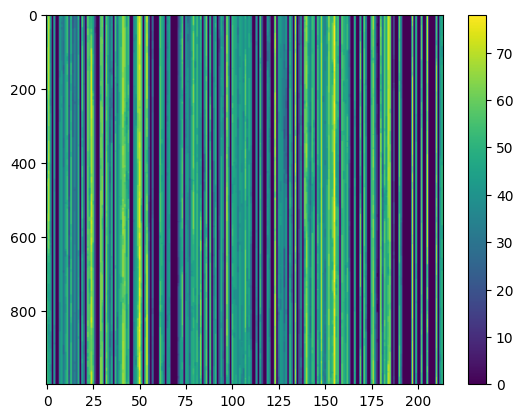

In [ ]:
plt.imshow(se_time_samples[:,:,0], aspect="auto")
plt.colorbar()

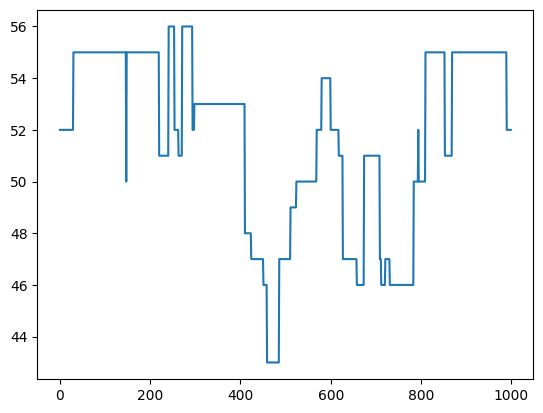

In [ ]:
# The resulting tensor is of shape [K, N, L], so we
# plot the SE (L=0) traceplot for the 101st individual (N=101)
plt.plot(se_time_samples[:,100,0])

### Exercise 4
Try experimenting with running the chain for longer and/or changing the arguments of the `adaptive_rwmh` and `move_events` kernels to see if you can improve the convergence and mixing.

### Exercise 5
Try changing which parameters are estimated and/or the parameter values used in the simulation to see if this makes a difference to how well the parameters can be inferred from the data.